In [41]:
%matplotlib inline

In [42]:
from __future__ import print_function
import tensorflow as tf
# tf.enable_eager_execution()
from keras.layers import Input, Dropout, Dot, Lambda, Activation
import keras.backend as K
from keras.models import Model
from keras.optimizers import Adam
from keras.regularizers import l2

from sklearn.utils import class_weight
from layers.graph import GraphConvolution
from utils import *

import time

In [49]:
# Define parameters
DATASET = 'cora'
FILTER = 'localpool'  # 'chebyshev'
MAX_DEGREE = 100  # maximum polynomial degree
SYM_NORM = True  # symmetric (True) vs. left-only (False) normalization
NB_EPOCH = 500
PATIENCE = 100  # early stopping patience

In [50]:
# Get data
X, A, y = load_data(dataset=DATASET)
y_train, y_val, y_test, idx_train, idx_val, idx_test, train_mask = get_splits(A.toarray())

# Normalize X
X /= X.sum(1).reshape(-1, 1)

if FILTER == 'localpool':
    """ Local pooling filters (see 'renormalization trick' in Kipf & Welling, arXiv 2016) """
    print('Using local pooling filters...')
    A_ = preprocess_adj(A, SYM_NORM)
    support = 1
    graph = [X, A_]
    G = [Input(shape=(None, None), batch_shape=(None, None), sparse=True)]

elif FILTER == 'chebyshev':
    """ Chebyshev polynomial basis filters (Defferard et al., NIPS 2016)  """
    print('Using Chebyshev polynomial basis filters...')
    L = normalized_laplacian(A, SYM_NORM)
    L_scaled = rescale_laplacian(L)
    T_k = chebyshev_polynomial(L_scaled, MAX_DEGREE)
    support = MAX_DEGREE + 1
    graph = [X]+T_k
    G = [Input(shape=(None, None), batch_shape=(None, None), sparse=True) for _ in range(support)]

else:
    raise Exception('Invalid filter type.')

Loading cora dataset...
Dataset has 2708 nodes, 5429 edges, 1433 features.
Using local pooling filters...


In [51]:
pos_weight = float(A.shape[0] * A.shape[0] - A.sum()) / A.sum()


In [52]:
X_in = Input(shape=(X.shape[1],))

# Define model architecture
# NOTE: We pass arguments for graph convolutional layers as a list of tensors.
# This is somewhat hacky, more elegant options would require rewriting the Layer base class.
H = Dropout(0.1)(X_in)
H = GraphConvolution(16, support, activation='relu', kernel_regularizer=l2(5e-4))([H]+G)
H = Dropout(0.1)(H)
# Y = GraphConvolution(y.shape[1], support, activation='softmax')([H]+G)
Y = Lambda(lambda x: K.dot(x, K.transpose(x)))(H)



In [55]:
def customLoss(yTrue,yPred):
    return tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(
        yPred,
        yTrue,
        pos_weight=pos_weight
    ))
    

====== <function customLoss at 0x0000017A86002B70>


C:\Users\Junhao\Anaconda3\lib\site-packages\sklearn\decomposition\pca.py:447: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


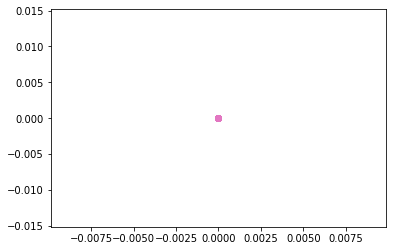

nmi 0.000648787978753054


C:\Users\Junhao\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


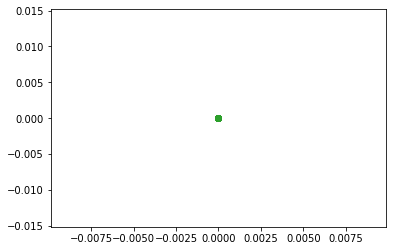

====== mean_absolute_percentage_error


C:\Users\Junhao\Anaconda3\lib\site-packages\sklearn\decomposition\pca.py:447: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


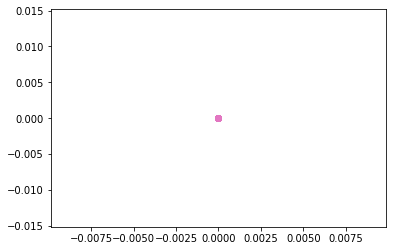

nmi 0.000648787978753054


C:\Users\Junhao\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


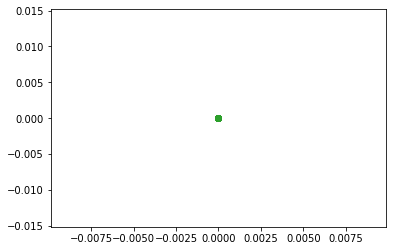

====== categorical_crossentropy


C:\Users\Junhao\Anaconda3\lib\site-packages\sklearn\decomposition\pca.py:447: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


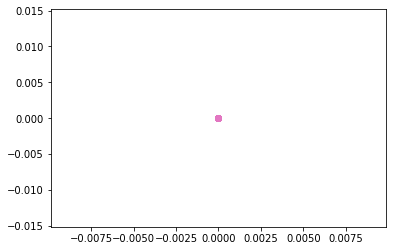

nmi 0.000648787978753054


C:\Users\Junhao\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


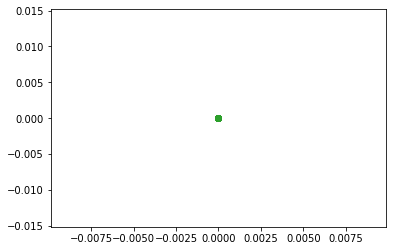

====== kullback_leibler_divergence


C:\Users\Junhao\Anaconda3\lib\site-packages\sklearn\decomposition\pca.py:447: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


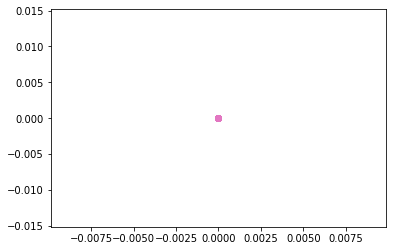

C:\Users\Junhao\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


nmi 0.000648787978753054


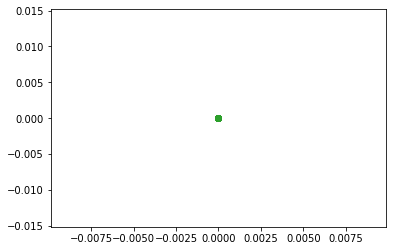

====== binary_crossentropy


C:\Users\Junhao\Anaconda3\lib\site-packages\sklearn\decomposition\pca.py:447: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


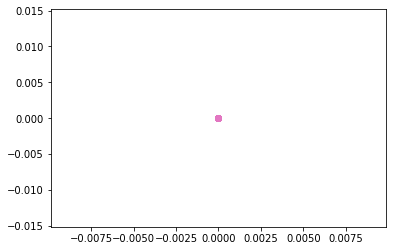

nmi 0.000648787978753054


C:\Users\Junhao\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


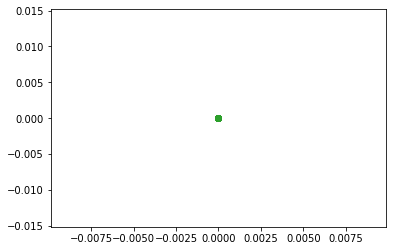

In [56]:
for loss_type in [customLoss, 'mean_absolute_percentage_error','categorical_crossentropy', 
                  'kullback_leibler_divergence', 'binary_crossentropy']:
    print('======', loss_type)
   
    # Compile model
    model = Model(inputs=[X_in]+G, outputs=Y)
    model.compile(loss=loss_type, optimizer=Adam(lr=0.01))

    encoder = Model(inputs=[X_in]+G, outputs=H)

    # Helper variables for main training loop
    wait = 0
    preds = None
    best_val_loss = 99999

    # Fit
    for epoch in range(1, NB_EPOCH+1):

        # Log wall-clock time
        t = time.time()
                
        # Single training iteration (we mask nodes without labels for loss calculation)
        model.fit(graph,y_train,
                  batch_size=A.shape[0], epochs=1, shuffle=False, verbose=False)

    embeddings = encoder.predict(graph, batch_size=A.shape[0])
    # Visualize
    labels = np.argwhere(y == 1)[:,1]

    from sklearn.decomposition import PCA
    from sklearn.metrics.cluster import adjusted_mutual_info_score

    X_embedded = PCA().fit_transform(embeddings)

    import matplotlib.pyplot as plt

    for i in set(labels):
        plt.scatter(X_embedded[np.argwhere(labels == i), 0], X_embedded[np.argwhere(labels == i), 1])
        # plt.show()
    plt.show()

    import hdbscan

    hdb_labels = hdbscan.HDBSCAN(min_samples=4, min_cluster_size=20).fit_predict(embeddings)
    print('nmi', adjusted_mutual_info_score(hdb_labels, labels))
    for i in set(hdb_labels):
        plt.scatter(X_embedded[np.argwhere(hdb_labels == i), 0], X_embedded[np.argwhere(hdb_labels == i), 1])
        # plt.show()
    plt.show()
        
   